In [2]:
import numpy as np
import json
import warnings
import operator

import h5py
from keras.models import model_from_json
from keras import backend as K

from matplotlib import pyplot as plt

warnings.filterwarnings("ignore")

size_title = 18
size_label = 14
n_pred = 2

base_path = "data/remote_ig/"

path_data_dict = base_path + "data_dict.txt"
path_inverted_wt = base_path + "inverted_weights.txt"
path_usage_wt = base_path + "usage_prediction.txt"
path_class_wt = base_path + "class_weights.txt"
path_test_data = base_path + "test_paths_dict.txt"
model_path = base_path + "trained_model.hdf5"

def read_file(file_path):
    with open(file_path, 'r') as data_file:
        data = json.loads(data_file.read())
    return data

class_weights = read_file(path_class_wt)
usage_weights = read_file(path_usage_wt)
inverted_weights = read_file(path_inverted_wt)
data_dict = read_file(path_data_dict)

def create_model(model_path):
    trained_model = h5py.File(model_path, 'r')
    model_config = json.loads(trained_model.get('model_config').value)
    loaded_model = model_from_json(model_config)
    dictionary = json.loads(trained_model.get('data_dictionary').value)
    compatibile_tools = json.loads(trained_model.get('compatible_tools').value)
    reverse_dictionary = dict((str(v), k) for k, v in dictionary.items())
    model_weights = list()
    weight_ctr = 0
    while True:
        try:
            d_key = "weight_" + str(weight_ctr)
            weights = trained_model.get(d_key).value
            model_weights.append(weights)
            weight_ctr += 1
        except Exception as exception:
            break
    # set the model weights
    loaded_model.set_weights(model_weights)
    return loaded_model, dictionary, reverse_dictionary, compatibile_tools

model, dictionary, reverse_dictionary, compatibile_tools = create_model(model_path)

Using TensorFlow backend.


In [3]:
reverse_dictionary

{'1': 'cshl_fastq_to_fasta',
 '2': 'rseqc_read_distribution',
 '3': 'NSPDK_candidateClust',
 '4': 'tabular_to_fastq',
 '5': 'seq_filter_by_mapping',
 '6': 'resistome_analyzer',
 '7': 'heinz_visualization',
 '8': 'lastz_wrapper_2',
 '9': 'bowtie_wrapper',
 '10': 'bed_to_bigwig',
 '11': 'cast',
 '12': 'deeptools_heatmapper',
 '13': 'vcfsort',
 '14': 'mothur_cluster',
 '15': 'blast_parser',
 '16': 'cardinal_combine',
 '17': 'rna_star',
 '18': 'NFS_transfer',
 '19': 'stringtie_merge',
 '20': 'minfi_dropsnp',
 '21': 'raceid_filtnormconf',
 '22': 'Paste1',
 '23': 'metilene',
 '24': 'antismash',
 '25': 'bam_to_sam',
 '26': 'gd_raxml',
 '27': 'bam_to_bigwig',
 '28': 'msconvert3_raw',
 '29': 'mothur_seq_error',
 '30': 'gatk2_variant_select',
 '31': 'fastq_paired_end_joiner',
 '32': 'wig_to_bigWig',
 '33': 'raceid_main',
 '34': 'ucsc-twobittofa',
 '35': 'flye',
 '36': 'Remove beginning1',
 '37': 'computeMatrix',
 '38': 'velvetg_jgi',
 '39': 'snpeff_to_peptides',
 '40': 'smooth_running_window',
 

In [104]:
def verify_model(model, tool_sequence, labels, dictionary, reverse_dictionary, compatible_tools, topk=30, max_seq_len=25):
    tl_seq = tool_sequence.split(",")
    last_tool_name = reverse_dictionary[str(tl_seq[-1])]
    last_compatible_tools = compatible_tools[last_tool_name]
    sample = np.zeros(max_seq_len)
    for idx, tool_id in enumerate(tl_seq):
        sample[idx] = int(tool_id)
    sample_reshaped = np.reshape(sample, (1, max_seq_len))
    
    tool_sequence_names = [reverse_dictionary[str(tool_pos)] for tool_pos in tool_sequence.split(",")]
    print("Tool seq: %s" % ",".join(tool_sequence_names))
    # predict next tools for a test path
    prediction = model.predict(sample_reshaped, verbose=0)
    prediction = np.reshape(prediction, (prediction.shape[1],))
    prediction_pos = np.argsort(prediction, axis=-1)

    # get topk prediction
    topk_prediction_pos = prediction_pos[-topk:]
    topk_prediction_val = [np.round(prediction[pos] * 100, 2) for pos in topk_prediction_pos]

    # read tool names using reverse dictionary
    pred_tool_ids = [reverse_dictionary[str(tool_pos)] for tool_pos in topk_prediction_pos]
    actual_next_tool_ids = list(set(pred_tool_ids).intersection(set(last_compatible_tools.split(","))))      
        
    #print("Predicted tools: %s" % ",".join(pred_tool_ids))
    print()
    pred_tool_ids_sorted = dict()
    for (tool_pos, tool_pred_val) in zip(topk_prediction_pos, topk_prediction_val):
        tool_name = reverse_dictionary[str(tool_pos)]
        #if tool_name in actual_next_tool_ids:
        pred_tool_ids_sorted[tool_name] = tool_pred_val
    pred_tool_ids_sorted = dict(sorted(pred_tool_ids_sorted.items(), key=lambda kv: kv[1], reverse=True))
    
    cls_wt = dict()
    usg_wt = dict()
    inv_wt = dict()
    ids_tools = dict()
    keys = list(pred_tool_ids_sorted.keys())
    for k in keys:
        try:
            cls_wt[k] = np.round(class_weights[str(data_dict[k])], 2)
            usg_wt[k] = np.round(usage_weights[k], 2)
            inv_wt[k] = np.round(inverted_weights[str(data_dict[k])], 2)
        except:
            continue
    print("Predicted tools: \n")
    print(pred_tool_ids_sorted)
    print()
    print("Class weights: \n")
    cls_wt = dict(sorted(cls_wt.items(), key=lambda kv: kv[1], reverse=True))
    print(cls_wt)
    print()
    print("Usage weights: \n")
    usg_wt = dict(sorted(usg_wt.items(), key=lambda kv: kv[1], reverse=True))
    print(usg_wt)
    print()
    print("Inverted weights: \n")
    inv_wt = dict(sorted(inv_wt.items(), key=lambda kv: kv[1], reverse=True))
    print(inv_wt)
    for key in pred_tool_ids_sorted:
        ids_tools[key] = dictionary[key]
    print()
    print("Tool ids")
    print(ids_tools)
    print("======================================")
    return cls_wt, usg_wt, inv_wt, pred_tool_ids_sorted

topk = 20
# 227,885,17,732,25,372,560,678,823,411,775,459,53,22,372,687,11
tool_seq = "227,885,17,732,25,372,560,678"
class_wt, usage_wt, inverse_wt, pred_tools = verify_model(model, tool_seq, "", dictionary, reverse_dictionary, compatibile_tools, topk)

Tool seq: __UNZIP_COLLECTION__,umi_tools_extract,rna_star,ngsutils_bam_filter,bam_to_sam,tp_awk_tool,tp_sed_tool,sam_to_bam

Predicted tools: 

{'umi_tools_dedup': 98.19, 'wig_to_bigWig': 1.34, 'tp_awk_tool': 0.78, 'fastqc': 0.5, 'datamash_transpose': 0.35, 'bam_to_sam': 0.22, 'melt': 0.21, 'bctools_extract_alignment_ends': 0.2, 'samtools_flagstat': 0.18, 'deeptools_compute_gc_bias': 0.17, 'extract_aln_ends.py': 0.14, 'tp_sed_tool': 0.13, 'bedtools_intersectbed': 0.11, 'picard_CollectInsertSizeMetrics': 0.1, 'heatmap2': 0.1, 'htseq_count': 0.09, '__SORTLIST__': 0.08, 'picard_FilterSamReads': 0.08, 'pureclip': 0.07, 'tsne': 0.06}

Class weights: 

{'fastqc': 46164.76, 'deeptools_compute_gc_bias': 14752.0, 'htseq_count': 13969.11, '__SORTLIST__': 11334.35, 'tp_sed_tool': 10430.6, 'picard_CollectInsertSizeMetrics': 9579.44, 'samtools_flagstat': 7073.15, 'bedtools_intersectbed': 6973.82, 'bam_to_sam': 6390.62, 'bctools_extract_alignment_ends': 6033.61, 'pureclip': 5597.13, 'wig_to_bigWig':

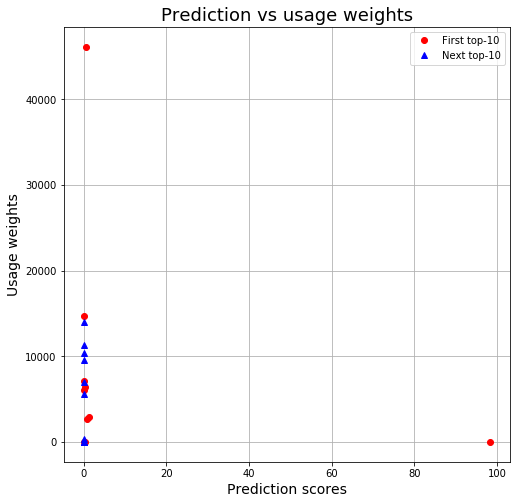

In [106]:
list_cls_wt = list()
list_usage_wt = list()
list_pred_wt = list()
division_pt = int(len(pred_tools) / 2)

for tool in pred_tools:
    list_pred_wt.append(pred_tools[tool])
    try:
        list_cls_wt.append(class_wt[tool])
    except:
        list_cls_wt.append(1)

def plot_scatter(x_val, y_val, title, xlabel, ylabel):
    plt.figure(figsize=(8, 8))
    plt.plot(x_val[:division_pt], y_val[:division_pt], 'ro')
    plt.plot(x_val[division_pt:], y_val[division_pt:], 'b^')
    plt.xlabel(xlabel, size=size_label)
    plt.ylabel(ylabel, size=size_label)
    plt.legend([("First top-%s" % str(division_pt)), ("Next top-%s" % str(division_pt))])
    plt.title(title, size=size_title)
    plt.grid(True)
    plt.show()

plot_scatter(list_pred_wt, list_cls_wt, "Prediction vs usage weights", "Prediction scores", "Usage weights")
#plot_scatter(ave_prediction_weights, ave_usage_weights, "Prediction vs usage weights", "Prediction scores", "Usage weights")
#plot_scatter(ave_prediction_weights, ave_inverted_weights, "Prediction vs inverted weights", "Prediction scores", "Inverted weights")